In [1]:
# Run this first.
!pip install graphviz
!pip install python-chess

import chess
import graphviz

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


# Repertoire Visualizer

Parses a sequence of opening lines and displays them as a DAG.

## Format

Each line is a whitespace-delimited sequence of moves, e.g. `e4 e5 Ke2`.

Moves can be annotated by evaluation (e.g. `e4 e5 Ke2!!` or `e4 e5 Qh4?`), and text entries can be added, delimieted by a semicolon, creating bubbles which point to the move (e.g. `e4 e5 Ke2;yolo;castling-is-weak` would add text nodes `yolo` and `castling-is-weak` to point to the move `Ke2`).

Lines are separated by newlines, and any empty line or line beginning with `#` will be ignored as a comment.

## Storage

Store your lines in one or more files under the `data` directory and name them in the list in the final cell.

In [2]:
colors = {
    "??": "red",
    "?": "orange",
    "?!": "yellow",
    "!!": "cyan",
    "!": "blue"
}


def parse_move(move):
    components = move.split(';')
    label = components[0]
    color = "black"
    remarks = []
    for assessment in colors:
        if label.endswith(assessment):
            color = colors[assessment]
            label = label.replace(assessment, '')
    if len(components) >= 2:
        remarks = [remark for remark in components[1:]]
    return label, color, remarks


class Repertoire:
    def __init__(self, name="Opening Repertoire"):
        self.graph = graphviz.Digraph(name=name, graph_attr={'rankdir':'LR'})
        self.positions = {}  # map of FENs to chess positions
        self.edges = set()
        self.starting_position = chess.Board()
        self._add_position(self.starting_position, "Start")

    def _add_position(self, position, label, color="black"):
        fen = position.fen()
        self.graph.node(fen, label=label, color=color)
        self.positions[fen] = position

    def _connect(self, fen1, fen2):
        edge = (fen1, fen2)
        if edge not in self.edges:
          self.graph.edge(*edge)
          self.edges.add(edge)
  
    def _annotate(self, fen, remark):
        self.graph.node(remark, color="gray")
        self._connect(remark, fen)

    def add_line(self, moves):
        last_pos = None
        for move_entry in moves.split():
            if last_pos is None:
                last_pos = self.starting_position
            next_pos = last_pos.copy()
            move, color, remarks = parse_move(move_entry)
            next_pos.push_san(move)
            self._add_position(next_pos, move, color)
            self._connect(last_pos.fen(), next_pos.fen())
            for remark in remarks:
                self._annotate(next_pos.fen(), remark)
            last_pos = next_pos

    def draw(self):
        return self.graph

## Instructions

To include a file, name it in the `filenames` list and run the following cell.

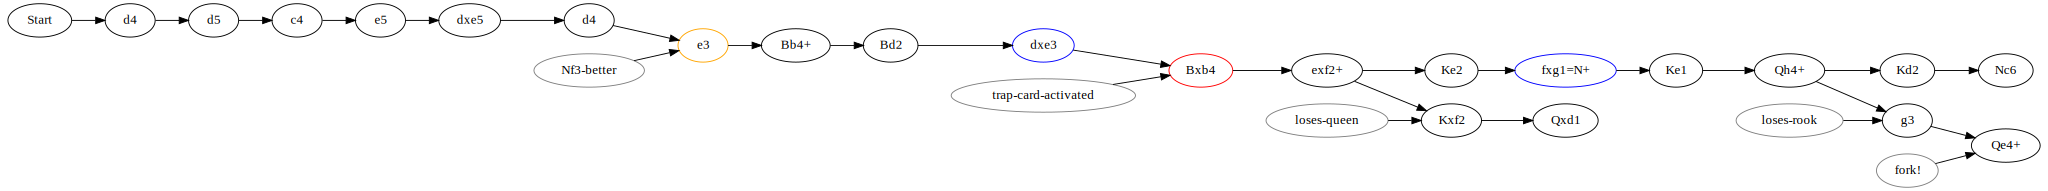

In [3]:
# List the files you wish to load.
data_prefix = '../data'
filenames = ['example_lasker']

# Parse each file for lines.
lines = []
for filename in filenames:
    with open(f'{data_prefix}/{filename}') as file:
        for line in file.readlines():
            line = line.strip()
            if line and not line.startswith('#'):
                lines.append(line)

# Load all included lines onto the graph and display it.
rep = Repertoire()
for line in lines:
    rep.add_line(line)
rep.draw()